Preparation of this workshop has been supported by the Polish National Agency for Academic Exchange<br>
under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001

In [1]:
using Random, Distributions, Statistics, Plots

h = 0.1 #storage cost
c = 2.0 #unit profit
K = 40 # fixed order cost
k = 1.0 # variable order cost
s = 30 # reorder point
S = 50 # target stock level

50

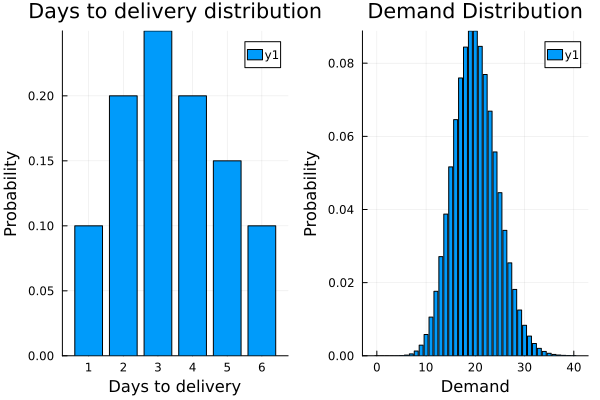

In [75]:
days_to_delivery = Distributions.Categorical([0.1, 0.2, 0.25, 0.2, 0.15, 0.1])
demand_dist = Distributions.Poisson(20) # average demand is 20

# plot days to delivery distribution on left and demand on the right

p1 = plot(1:6, pdf.(days_to_delivery, 1:6), seriestype=:bar, title="Days to delivery distribution", xlabel="Days to delivery", ylabel="Probability");
p2 = plot(0:40, pdf.(demand_dist, 0:40), seriestype=:bar, xlabel="Demand", ylabel="Probability", title="Demand Distribution");
# Align p1 to left and p2 to right
plot(p1, p2, layout=(1,2))

In [76]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulate_inventory(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    days_to_delivery = Distributions.Categorical([0.1, 0.2, 0.25, 0.2, 0.15, 0.1]),
    demand_dist = Distributions.Poisson(20))

    @assert 0 <= s <= S
    X0 = init_S #initial warehouse level
    profit = 0.0 # total profit
    lost_orders = 0 # total lost orders
    warehouse_levels = Int[] # warehouse levels at the end of each day
    order_arrives = 0 # order arrives on this day (0 if no order)

    for day in 1:m
        if X0 < s && order_arrives == 0  # reorder
            # the order has arrived
            order_arrives = day + rand(days_to_delivery)
        end
        if order_arrives == day
            X0 = S
            order_arrives = 0
            profit -= K + (S-X0)*k
        end
        demand = rand(demand_dist)
        sales = min(X0, demand)
        X0 -= sales
        lost_order = demand - sales # failed to provide those orders
        profit += sales*c - X0*h  # storage costs
        lost_orders += lost_order
        push!(warehouse_levels, X0)
    end
    return (; profit, lost_orders,  warehouse_levels )
end

simulate_inventory (generic function with 1 method)

In [77]:
res = simulate_inventory(50,50,200)

(profit = 2417.3000000000006, lost_orders = 158, warehouse_levels = [83, 69, 51, 32, 17, 0, 0, 0, 187, 165  …  71, 48, 35, 15, 0, 176, 152, 136, 116, 100])

In [86]:
Random.seed!(10)
res = simulate_inventory(50,50,200)
res.warehouse_levels'

1×50 adjoint(::Vector{Int64}) with eltype Int64:
 79  60  38  22  0  178  164  141  122  …  161  138  113  89  69  51  31  0

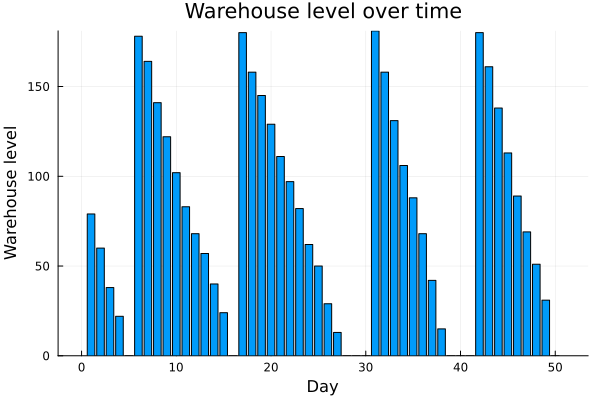

In [89]:
using Plots
bar(res.warehouse_levels, xlabel="Day", ylabel="Warehouse level", title="Warehouse level over time", legend=false)

In [90]:
using DataFrames
df = DataFrame( simulate_inventory(10,20,40) for _ in 1:10  )

Row,profit,lost_orders,warehouse_levels
,Float64,Int64,Array…
1,378.9,81,"[82, 62, 38, 14, 0, 0, 0, 0, 0, 15]"
2,439.3,65,"[75, 56, 41, 17, 0, 0, 18, 0, 0, 0]"
3,434.5,42,"[82, 60, 42, 27, 7, 0, 0, 29, 8, 0]"
4,435.8,57,"[80, 65, 45, 28, 3, 0, 0, 0, 21, 0]"
5,436.6,41,"[79, 64, 46, 20, 4, 0, 18, 3, 0, 0]"
6,440.3,78,"[84, 56, 34, 10, 0, 0, 0, 13, 0, 0]"
7,431.4,42,"[83, 69, 53, 36, 19, 3, 0, 19, 4, 0]"
8,432.6,37,"[83, 70, 54, 30, 10, 0, 0, 21, 6, 0]"
9,440.8,66,"[74, 55, 30, 15, 0, 0, 0, 18, 0, 0]"


In [92]:

function run_sims(m,s,S,N=100; kwargs...)
    df = DataFrame(simulate_inventory(m,s,S; kwargs...) for _ in 1:N)
    return (;
        m,
        s,
        S,
        N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders),
        kwargs...
    )
end

run_sims(30,50,100,1000, k=2, c=4)

(m = 30, s = 50, S = 100, N = 1000, profit_mean = 1355.8993999999998, profit_std = 121.55859604286286, lost_mean = 132.282, lost_std = 44.14030859478491, k = 2, c = 4)

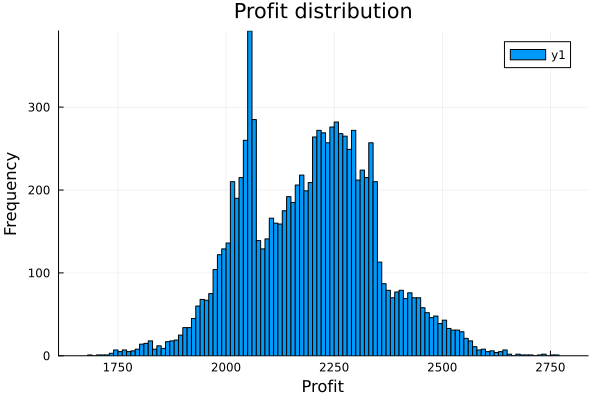

In [93]:
df = DataFrame(simulate_inventory(50,50,100) for _ in 1:10_000)
histogram(df.profit, bins=100, xlabel="Profit", ylabel="Frequency", title="Profit distribution")

In [95]:
df = DataFrame( run_sims(90,s,S,1000) for s in 20:10:250,
                S in 50:50:500 if s < S )

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,20,50,1000,1833.14,107.378,934.158,66.4615
2,90,30,50,1000,1959.31,122.428,859.507,71.8636
3,90,40,50,1000,2107.74,125.458,766.991,76.7433
4,90,20,100,1000,3284.88,192.145,652.429,70.5454
5,90,30,100,1000,3483.36,199.109,578.318,75.0462
6,90,40,100,1000,3688.51,208.409,499.845,78.2986
7,90,50,100,1000,3856.89,195.641,427.43,75.3767
8,90,60,100,1000,4022.58,192.216,355.486,71.0458
9,90,70,100,1000,4152.26,188.007,277.989,72.1892


In [96]:
#biggest profit
df[argmax(df.profit_mean),:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
51,90,100,250,1000,5121.16,173.22,44.369,31.7191


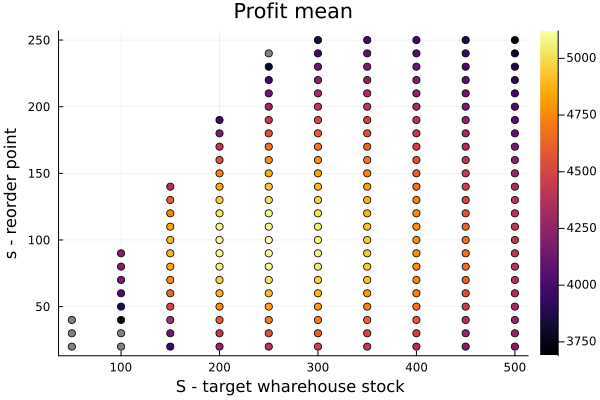

In [98]:
more3500 = findall(>(3500), df.profit_mean)

p1 = scatter(df.S[more3500],
        df.s[more3500],
        zcolor= df.profit_mean[more3500],
        xlabel = "S - target wharehouse stock ",
        ylabel="s - reorder point", title="Profit mean",label=nothing)
scatter!(p1, df.S[Not(more3500)],
        df.s[Not(more3500)],
        markercolor="gray",label=nothing)


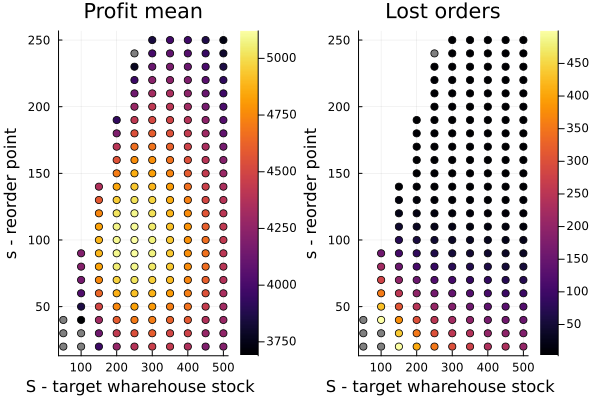

In [99]:
more3500 = findall(>(3500), df.profit_mean)

p2 = scatter(df.S[more3500],
        df.s[more3500],
        zcolor= df.lost_mean[more3500],
        xlabel = "S - target wharehouse stock ",
        ylabel="s - reorder point", title="Lost orders",label=nothing)
scatter!(p2, df.S[Not(more3500)],
        df.s[Not(more3500)],
        markercolor="gray",label=nothing)
plot(p1, p2, layout=(1,2))

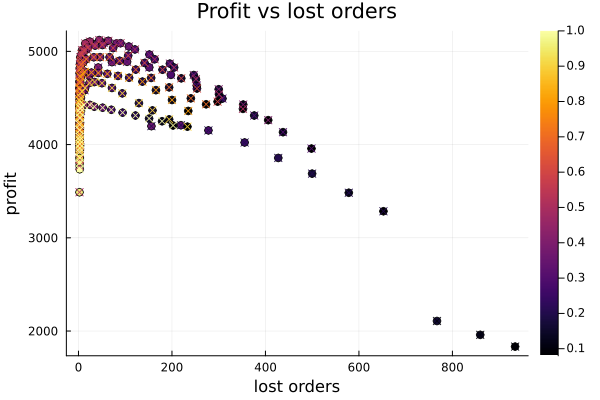

In [101]:

scatter(df.lost_mean[more500],df.profit_mean[more500], marker=:o, zcolor=df.s[more500]./maximum(df.s[more500]), xlabel="lost orders", ylabel="profit", title="Profit vs lost orders",label=nothing)
scatter!(df.lost_mean[more500],df.profit_mean[more500], marker=:x, zcolor=df.S[more500]./maximum(df.S[more500]),label=nothing)
